In [2]:
from load_data import DATA_DIR

import os
import json
import numpy as np
import torch
import torchvision
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2

P53_CLASS_CODES = ["WT", "OE", "NM", "DC"]

BOLERO_DIR = os.path.join(DATA_DIR, '..', 'BOLERO')
PATHXL_DIR = os.path.join(DATA_DIR, '..', 'p53_consensus_study')

BASE_DIR = {
    'test': DATA_DIR,
    'pathxl': PATHXL_DIR,
    'bolero': BOLERO_DIR,
}
FIG_DIR = os.path.join(DATA_DIR, '..', '..', 'images')

color_dict = {
    "r": '#DA4C4C', # Red
    "o": '#E57439', # Orange
    "y": '#EDB732', # Yellow
    "g": '#479A5F', # Green
    "lb": '#5BC5DB', # Light blue
    "b": '#5387DD', # Blue
    "p": '#7D54B2', # Purple
    "pi": '#E87B9F', # Pink
#  '#229487', # Dark green/Turquoise
#  '#C565C7', # Lilac
    "r_p": '#E89393', # Pale red
    "o_p": '#EFAB88', # Pale orange
    "y_p": '#F4D384', # Pale yellow
    "g_p": '#90C29F', # Pale green
    "lb_p":'#9CDCE9', # Pale light blue
    "b_p": '#98B7EA', # Pale blue
    "p_p": "#B198D0", # Pale purple
}

C:\Users\321lu\AppData\Local\Temp\ipykernel_1184\2529084980.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Data Distribution

In [14]:
def get_labels(data_name):
    if data_name == "test":
        return pd.read_csv(os.path.join(BASE_DIR[data_name], 'test.csv')).set_index("id")
    elif data_name == "train":
        return pd.read_csv(os.path.join(BASE_DIR['test'], 'train.csv')).set_index("id")
    elif data_name == "bolero":
        labels = pd.read_csv(os.path.join(BASE_DIR[data_name], 'P53_BOLERO_T.csv'))
        labels = labels.sort_values(by="Case ID")
        labels = labels.reset_index(drop=True)
        # Map GS to {1:0, 2:1, 3:2, 4:4} where 4 is unknown
        labels["label"] = labels["GS"].map({1:0, 2:1, 3:2, 4:4})
        return labels
    elif data_name == "pathxl":
        labels = pd.read_csv(os.path.join(BASE_DIR[data_name], 'labels.csv'))
        # idx is id column and biopsy_nr column separated by _
        labels["idx"] = labels["id"].astype(str) + "_" + labels["biopsy_nr"].astype(str)
        labels = labels.set_index("idx")
        # Sort by id primarily and biopsy_nr secondarily
        labels = labels.sort_values(by=["id", "biopsy_nr"])
        # Map label
        mapping = {"WT":0, "Overexpression":1, "Null":2, "Double clones":3}
        labels["label"] = labels["label"].map(mapping)
        # Filter out any concordance % < 100
        labels = labels[labels["concordance %"] == 100]
        return labels

# Make LaTeX table of label counts
table = ""
table += "Dataset & Level & Total & WT & OE & NM & DC & X \\\\ \n"

all_labels = {}
for i, data_name in enumerate(["train", "test", "pathxl", "bolero"]):
    labels = get_labels(data_name)
    # print(f"Dataset: {data_name}")
    value_counts = labels["label"].value_counts()
    # print(value_counts)
    # print()

    table += f'{["train", "test 1", "test 2", "BOLERO"][i]} & '
    table += f'{["biopsy", "biopsy", "biopsy", "WSI"][i]} & '
    table += f"{len(labels)} & "
    for j, code in enumerate(P53_CLASS_CODES+["X"]):
        table += f"{value_counts.get(j, 0)} & "
    table += "\\\\ \n"

    labels = labels["label"].to_dict()
    all_labels.update({f"{data_name}_{k}": v for k, v in labels.items()})

print(table)

Dataset & Level & Total & WT & OE & NM & DC & X \\ 
train & biopsy & 1472 & 1125 & 251 & 96 & 0 & 0 & \\ 
test 1 & biopsy & 60 & 15 & 15 & 15 & 15 & 0 & \\ 
test 2 & biopsy & 483 & 370 & 55 & 29 & 29 & 0 & \\ 
BOLERO & WSI & 55 & 22 & 28 & 4 & 0 & 1 & \\ 



# Biopsy Dimensions

In [11]:
for data_name in ['test', 'pathxl', 'bolero']:
    if os.path.exists(os.path.join(BASE_DIR[data_name], 'biopsy_dims.json')):
        continue
    print(data_name)

    biopsy_dims = {}
    for img_filename in tqdm(os.listdir(os.path.join(BASE_DIR[data_name], 'biopsies'))):
        img = plt.imread(os.path.join(BASE_DIR[data_name], 'biopsies', img_filename))
        biopsy_dims[img_filename.split('.')[0]] = img.shape[:2]

    with open(os.path.join(BASE_DIR[data_name], 'biopsy_dims.json'), 'w') as f:
        json.dump(biopsy_dims, f)

test 5.330938
pathxl 6.388872
bolero 5.630974


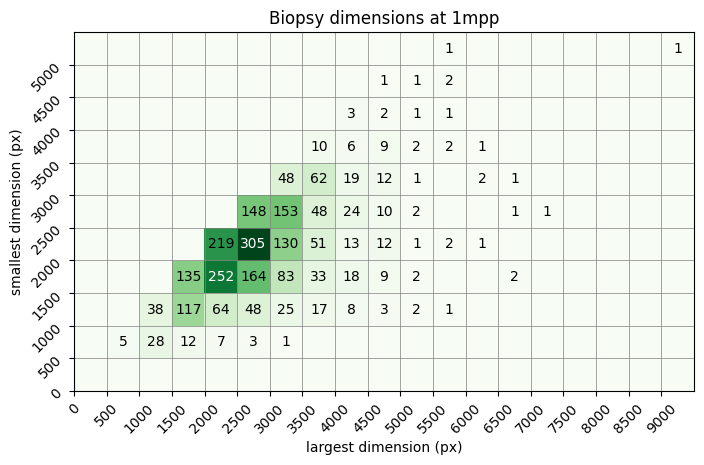

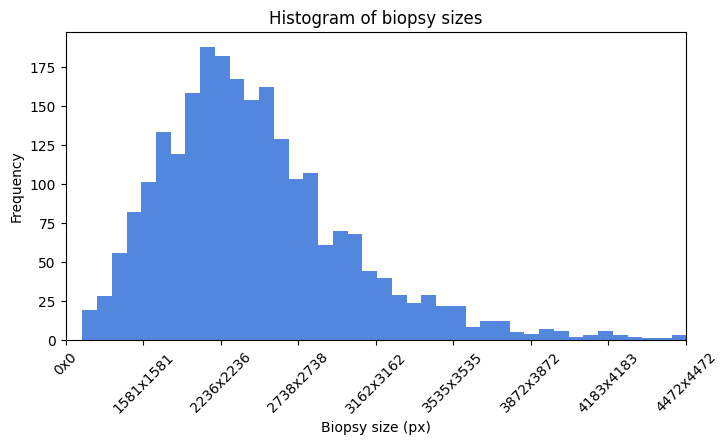

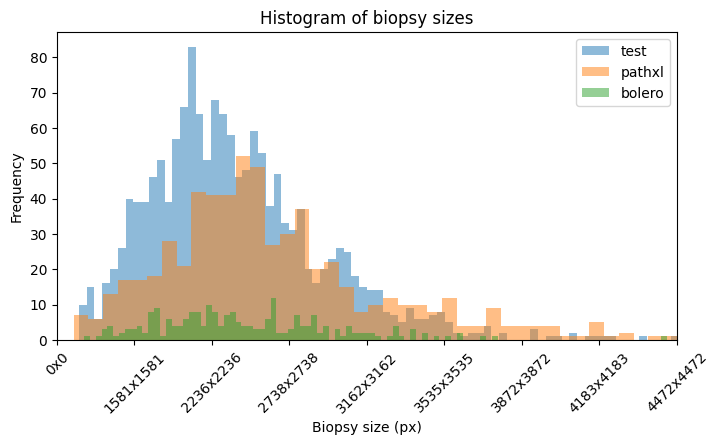

In [12]:
biopsy_dims = {}

for data_name in ['test', 'pathxl', 'bolero']:
    with open(os.path.join(BASE_DIR[data_name], 'biopsy_dims.json')) as f:
        b_dims = json.load(f) # dict of biopsy dimensions (height, width)

    # Print median size in megapixels
    print(data_name, np.median([dim[0] * dim[1] for dim in b_dims.values()]) / 1e6)

    biopsy_dims.update({f'{data_name}_{k}': v for k, v in b_dims.items()})

# Sort so that the smallest dimension out of height and width is first
biopsy_dims = {k: tuple(sorted(v)) for k, v in biopsy_dims.items()}

# Make heatmap of biopsy dimensions in bins of {binsize} px
binsize = 500
max_dim0 = max(dim[0] for dim in biopsy_dims.values())
max_dim1 = max(dim[1] for dim in biopsy_dims.values())
bin_count0 = max_dim0 // binsize + 1
bin_count1 = max_dim1 // binsize + 1
bins = np.zeros((bin_count0, bin_count1))
for dim in biopsy_dims.values():
    i = dim[0] // binsize
    j = dim[1] // binsize
    bins[i, j] += 1
max_count = np.max(bins)


# Plot heatmap
plt.figure(figsize=(8,8))
plt.imshow(bins, cmap='Greens', interpolation='nearest') # good colormaps: hot, jet, viridis
plt.gca().invert_yaxis()
plt.yticks(np.arange(bin_count0)-0.5, [str(i * binsize) for i in range(bin_count0)], rotation=45)
plt.xticks(np.arange(bin_count1)-0.5, [str(i * binsize) for i in range(bin_count1)], rotation=45)
# put text on heatmap
for i in range(bin_count0):
    for j in range(bin_count1):
        if bins[i, j] == 0:
            continue
        color = 'black' if bins[i, j] < max_count * 0.75 else 'white'
        plt.text(j, i, str(int(bins[i, j])), color=color, ha='center', va='center')
# plt.colorbar()
plt.title('Biopsy dimensions at 1mpp')
plt.ylabel('smallest dimension (px)')
plt.xlabel('largest dimension (px)')
# Add grid lines between bins
for i in range(bin_count0):
    plt.axhline(i - 0.5, color='grey', linewidth=0.5)
for j in range(bin_count1):
    plt.axvline(j - 0.5, color='grey', linewidth=0.5)
plt.show()


# Plot histogram of biopsy sizes
plt.figure(figsize=(8,4))
plt.hist([dim[0] * dim[1] for dim in biopsy_dims.values()], bins=100, color=color_dict['b'])
plt.xlim(0, 2e7)

# Make x labels the root of the x labels as f"root x root"
# So the x labels are the dimensions instead of the area
xticks = plt.xticks()[0]
xticklabels = [f"{int(np.sqrt(x))}x{int(np.sqrt(x))}" for x in xticks if x >= 0]
plt.xticks(xticks, xticklabels, rotation=45)

plt.xlabel('Biopsy size (px)')
plt.ylabel('Frequency')
plt.title('Histogram of biopsy sizes')
plt.show()

# Plot histogram of biopsy sizes for each dataset on top of each other
plt.figure(figsize=(8,4))
for data_name in ['test', 'pathxl', 'bolero']:
    plt.hist([dim[0] * dim[1] for i, dim in biopsy_dims.items() if data_name in i], bins=100, alpha=0.5, label=data_name)
plt.xlim(0, 2e7)
plt.legend()
xticks = plt.xticks()[0]
xticklabels = [f"{int(np.sqrt(x))}x{int(np.sqrt(x))}" for x in xticks if x >= 0]
plt.xticks(xticks, xticklabels, rotation=45)
plt.xlabel('Biopsy size (px)')
plt.ylabel('Frequency')
plt.title('Histogram of biopsy sizes')
plt.show()

WT: 374 biopsies
Median size: 6097146.0
OE: 69 biopsies
Median size: 6156800.0
NM: 43 biopsies
Median size: 6486144.0
DC: 44 biopsies
Median size: 7123926.5


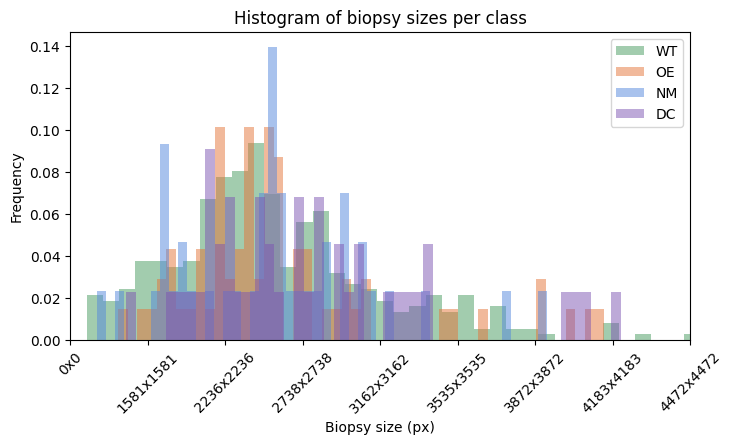

In [19]:
# Do the same per class
plt.figure(figsize=(8,4))
colors = [color_dict['g'], color_dict['o'], color_dict['b'], color_dict['p']]
# all_labels has the same keys as biopsy_dims, "{data_name}_{id}": label
for label in range(4):
    # plt.hist([dim[0] * dim[1] for i, dim in biopsy_dims.items() if all_labels.get(i, 4) == label], bins=100, alpha=0.5, label=P53_CLASS_CODES[label])
    # Have the height reflect the proportion of biopsies for that size in that class, not the count
    sizes = [dim[0] * dim[1] for i, dim in biopsy_dims.items() if all_labels.get(i, 4) == label]
    print(f"{P53_CLASS_CODES[label]}: {len(sizes)} biopsies")
    print(f"Median size: {np.median(sizes)}")
    plt.hist(sizes, bins=50, alpha=0.5, label=P53_CLASS_CODES[label], weights=np.ones_like(sizes) / len(sizes), color=colors[label])
plt.xlim(0, 2e7)
plt.legend()
xticks = plt.xticks()[0]
xticklabels = [f"{int(np.sqrt(x))}x{int(np.sqrt(x))}" for x in xticks if x >= 0]
plt.xticks(xticks, xticklabels, rotation=45)
plt.xlabel('Biopsy size (px)')
plt.ylabel('Frequency')
plt.title('Histogram of biopsy sizes per class')
plt.show()

In [21]:
# For the test set, get the masks and their size
NM_sizes = {}
for i, img_filename in tqdm(enumerate(os.listdir(os.path.join(BASE_DIR['test'], 'masks')))):
    img = plt.imread(os.path.join(BASE_DIR['test'], 'masks', img_filename))
    NM_sizes[img_filename.split('.')[0]] = img.sum()

In [37]:
# Plot sizes for NM biopsies VS sizes for DC biopsies
for label in [2, 3]:
    indices = [k.replace('test_','').replace('train_','') for k, v in all_labels.items() if v == label and ('test' in k or 'train' in k)]
    nm_size = [NM_sizes[i] for i in indices]
    print(f"{P53_CLASS_CODES[label]}: {len(nm_size)} biopsies")
    print(f"Median size: {np.median(nm_size)}")
#     plt.hist(nm_size, bins=50, alpha=0.5, label=P53_CLASS_CODES[label], weights=np.ones_like(nm_size) / len(nm_size), color=colors[label])
# plt.legend()
# plt.xlabel('Mask size (px)')
# plt.ylabel('Frequency')
# plt.title('Histogram of mask sizes per class')
# plt.show()
print()

# Another time but now for mask size as proportion of biopsy size
for label in [2, 3]:
    indices = [k.replace('test_','').replace('train_','') for k, v in all_labels.items() if v == label and ('test' in k or 'train' in k)]
    biopsy_size = [biopsy_dims[f'test_{i}'][0] * biopsy_dims[f'test_{i}'][1] for i in indices]
    nm_proportion = [NM_sizes[i] / s for i, s in zip(indices, biopsy_size)]
    print(f"{P53_CLASS_CODES[label]}: {len(nm_size)} biopsies")
    print(f"Median biopsy size: {np.median(biopsy_size)}")
    print(f"Median nullmutation proportion: {np.median(nm_proportion)}")
#     plt.hist(nm_proportion, bins=50, alpha=0.5, label=P53_CLASS_CODES[label], weights=np.ones_like(nm_proportion) / len(nm_proportion), color=colors[label])
# plt.legend()
# plt.xlabel('Mask size as proportion of biopsy size')
# plt.ylabel('Frequency')
# plt.title('Histogram of mask sizes as proportion of biopsy size per class')
# plt.show()

NM: 111 biopsies
Median size: 731607.0
DC: 15 biopsies
Median size: 213703.0

NM: 15 biopsies
Median biopsy size: 5101340.0
Median nullmutation proportion: 0.13655534220271567
DC: 15 biopsies
Median biopsy size: 6412664.0
Median nullmutation proportion: 0.055213292316329994


# Spacing examples

In [43]:
# Show most square biopsies
# biopsy_dims_list = sorted(biopsy_dims.items(), key=lambda x: x[1][1] / x[1][0])
biopsy_dims_list = sorted(biopsy_dims.items(), key=lambda x: abs(x[1][0] - 2048))
leeway = 0.05
for i, (k, v) in enumerate(biopsy_dims_list[:]):
    if v[0] / v[1] > 1+leeway or v[0] / v[1] < 1-leeway:
        continue
    if abs(v[0] - 2048) > 0.05 * 2048:
        continue

    print(f'{i+1}. {k}: {v[0]}x{v[1]}')

    # plt.figure(figsize=(2, 2))
    # plt.imshow(plt.imread(os.path.join(DATA_DIR, 'biopsies', f'{k}.png')))
    # plt.axis('off')
    # plt.show()

5. pathxl_76_5: 2049x2148
7. test_559: 2050x2115
12. pathxl_122_8: 2052x2144
23. test_1398: 2040x2127
26. test_387: 2058x2152
36. test_1392: 2061x2166
37. pathxl_96_4: 2035x2048
39. test_640: 2063x2095
40. test_1121: 2063x2078
47. test_1133: 2032x2052
53. test_97: 2031x2136
58. test_558: 2066x2149
79. pathxl_82_3: 2071x2100
87. test_1003: 2023x2056
90. test_444: 2075x2075
95. pathxl_76_4: 2075x2155
120. test_194: 2012x2020
149. pathxl_88_6: 2094x2161
154. pathxl_41_4: 2095x2197
161. test_1306: 2000x2032
171. test_338: 1996x2096
178. test_1261: 2101x2132
182. test_1343: 1994x1994
191. test_1117: 2104x2206
194. test_1517: 2104x2189
195. pathxl_0_1: 2104x2135
201. test_410: 1987x2072
204. pathxl_92_3: 2109x2198
206. pathxl_32_1: 1986x1998
211. test_749: 1984x2040
225. test_848: 1979x2013
226. test_1154: 2118x2222
227. pathxl_0_3: 2118x2157
261. test_981: 2128x2176
277. test_417: 2135x2223
280. pathxl_54_1: 2135x2219
291. test_1361: 2138x2153
293. bolero_39_0: 2138x2155
305. pathxl_61_2: 1

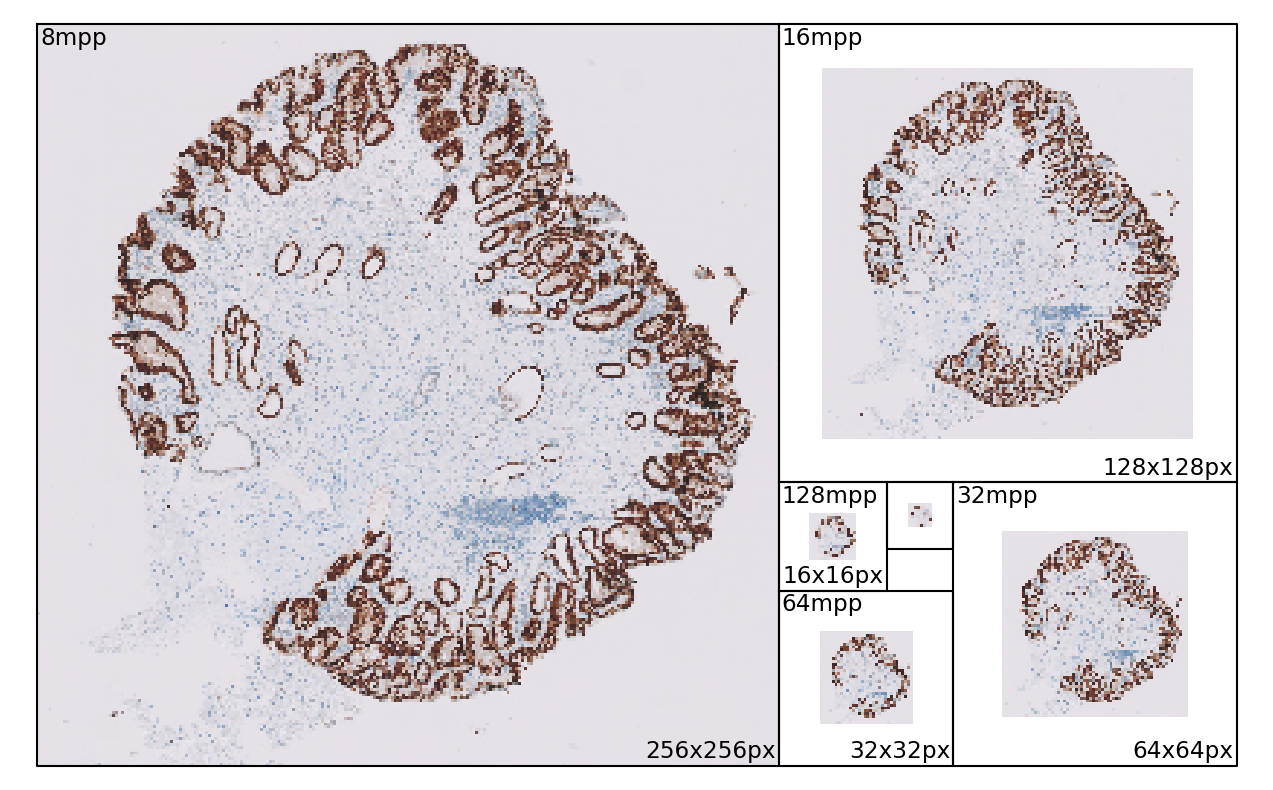

In [106]:
# Take biopsy img
# idx = 179
# idx = 1133
idx = 1361
img = plt.imread(os.path.join(DATA_DIR, 'biopsies', f'{idx}.png'))

img = torch.nn.functional.interpolate(torch.tensor(img).permute(2, 0, 1).unsqueeze(0).float(), (2048, 2048)).squeeze().permute(1, 2, 0).numpy()
img_height = img.shape[0]
img_width = img.shape[1]

spacings = [8,16,32,64,128,256]

first_img_spacing_size = max(img.shape) // spacings[0]

# for spacing in spacings:
#     # Plot biopsy img
#     plt.imshow(img[::spacing, ::spacing])
#     plt.title(f'Biopsy image at {spacing}mpp')
#     plt.show()

# For aesthetic purposes, plot the biopsies in a golden ratio grid
# First calculate the cell positions for the golden ratio grid
golden_ratio = (1 + 5**0.5) / 2
cell_positions = []
# Start with the first cell at the origin
cell_width = first_img_spacing_size
x0, y0, x1, y1 = 0, 0, cell_width, cell_width
cell_positions.append((x0, y0, x1, y1))
cell_width /= golden_ratio
x0 = x1
x1 = x0 + cell_width
y0 = y0
y1 = y0 + cell_width
cell_positions.append((x0, y0, x1, y1))
cell_width /= golden_ratio
x0 = x1 - cell_width
x1 = x0 + cell_width
y0 = y1
y1 = y1 + cell_width
cell_positions.append((x0, y0, x1, y1))
cell_width /= golden_ratio
x0 = x0 - cell_width
x1 = x0 + cell_width
y0 = y1 - cell_width
y1 = y0 + cell_width
cell_positions.append((x0, y0, x1, y1))
cell_width /= golden_ratio
x0 = x0
x1 = x0 + cell_width
y0 = y0 - cell_width
y1 = y0 + cell_width
cell_positions.append((x0, y0, x1, y1))
cell_width /= golden_ratio
x0 = x1
x1 = x0 + cell_width
y0 = y0
y1 = y0 + cell_width
cell_positions.append((x0, y0, x1, y1))

plt.figure(figsize=(10*golden_ratio, 10))

# First just plot the golden ratio grid
plt.axis('equal')
plt.axis('off')
# plt.title('Spacing\n(original image: 2048x2048px at 1mpp)', fontsize=10)

# Now plot the biopsies in the grid
for i, (x0, y0, x1, y1) in enumerate(cell_positions):
    sp = spacings[i]
    sub_img_width = img_width // sp
    sub_img_height = img_height // sp
    sub_img = torch.nn.functional.interpolate(torch.tensor(img).permute(2, 0, 1).unsqueeze(0).float(), (sub_img_height, sub_img_width)).squeeze().permute(1, 2, 0).numpy()

    if sp < 256:
        fontsize = 10*10/6
        # Add text with spacing, and dimensions
        plt.text(x0+1, y0+1, f'{sp}mpp', color='black', ha='left', va='top', fontsize=fontsize)
        # In bottom right corner add text with dimensions
        plt.text(x1-1, y1-1, f'{sub_img_width}x{sub_img_height}px', color='black', ha='right', va='bottom', fontsize=fontsize)
    # Make extent center the image in the cell without stretching it
    x_center = (x0 + x1) / 2
    y_center = (y0 + y1) / 2
    x0 = x_center - sub_img_width / 2
    x1 = x_center + sub_img_width / 2
    y0 = y_center - sub_img_height / 2
    y1 = y_center + sub_img_height / 2
    # Flip img 
    sub_img = np.flip(sub_img, axis=0)
    # Make sure the pixels show up sharp
    plt.imshow(sub_img, extent=(x0, x1, y0, y1), interpolation='nearest')

# Add grid lines between golden ratio cells
for i, (x0, y0, x1, y1) in enumerate(cell_positions):
    plt.plot([x0, x1, x1, x0, x0], [y0, y0, y1, y1, y0], 'k-')


# Change extent to show all cells
plt.xlim(-5, golden_ratio * first_img_spacing_size+5)
plt.ylim(-5, first_img_spacing_size+5)
plt.gca().invert_yaxis()

plt.savefig(os.path.join(FIG_DIR, 'spacing.png'), 
            bbox_inches='tight', pad_inches=-0.05
            )

plt.show()

pathxl_154_1 (3894, 3909)
pathxl_24_2 (3909, 3942)
pathxl_47_1 (4174, 4190)
pathxl_56_4 (4054, 4383)
pathxl_56_5 (4032, 4276)
pathxl_81_3 (3721, 4084)


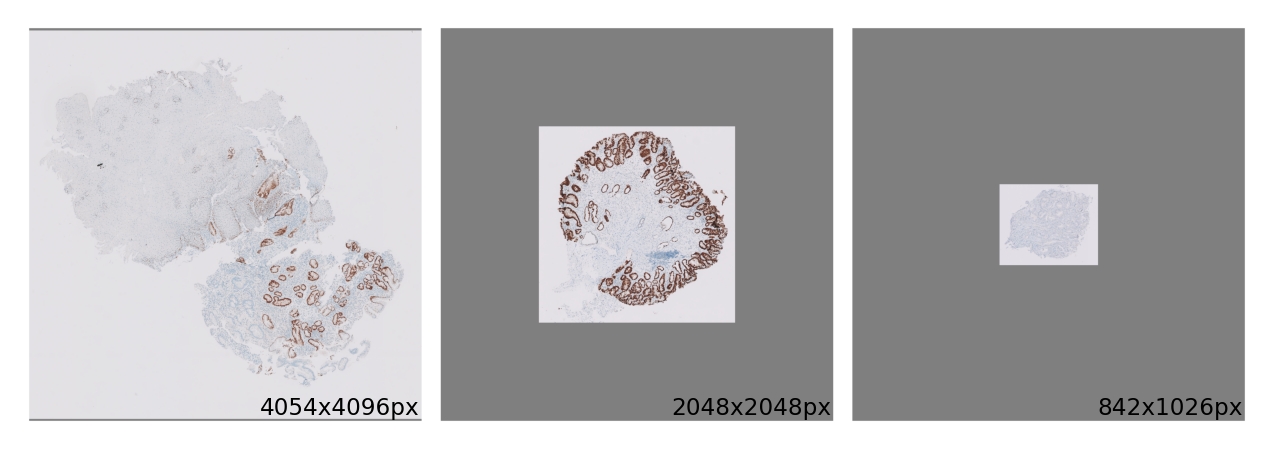

In [85]:
# Biopsies that have their largest side == 4096 (test 1410)
for k, v in biopsy_dims.items():
    if abs(v[0] - 4096) + abs(v[1] - 4096) < 400:
    # if max(v) > 9000:
        print(k, v)

# indices = [1385, 1361, 95, 352]
# indices = [1385, 1361, 95]
indices = [("pathxl", '56_4'), ('test', '1361'), ('test', '95')]

# Plot these biopsies from test in a row of 3
# Zero-pad them first into a frame of 4096x4096
# fig, axs = plt.subplots(1, 3, figsize=(15, 5))

images = []
shapes = []

show_size = 1024

for i, idx in enumerate(indices):
    data_name, idx = idx
    img = plt.imread(os.path.join(BASE_DIR[data_name], 'biopsies', f'{idx}.png'))

    if i == 0:
        # Rotate 90 degrees
        # img = np.rot90(img)
        x = 100
        y = 0
        img = img[y:y+4096, x:x+4096]
    elif i == 1:
        # Reshape to 2048x2048
        img = torch.nn.functional.interpolate(torch.tensor(img).permute(2, 0, 1).unsqueeze(0).float(), (2048, 2048)).squeeze().permute(1, 2, 0).numpy()

    frame = np.zeros((4096, 4096, 3))+0.5
    # Place the image in the center of the frame
    y = 2048 - img.shape[0]//2
    x = 2048 - img.shape[1]//2
    frame[y:y+img.shape[0], x:x+img.shape[1]] = img

    # Resize frame to 512x512
    frame = torch.nn.functional.interpolate(torch.tensor(frame).permute(2, 0, 1).unsqueeze(0).float(), (show_size, show_size)).squeeze().permute(1, 2, 0).numpy()
    
    # axs[i].imshow(frame)
    # axs[i].axis('off')
    # axs[i].set_title(f'{img.shape[0]}x{img.shape[1]}px', fontsize=10)
    images.append(frame)
    shapes.append(img.shape)

grid_padding = 50

# Make a single plot with all 3 images using make_grid
images = torch.tensor(np.array(images)).permute(0, 3, 1, 2)
grid = torchvision.utils.make_grid(images, nrow=3, padding=grid_padding, pad_value=1)
fsize = 10
plt.figure(figsize=(fsize*golden_ratio, fsize))
plt.imshow(grid.permute(1, 2, 0))
# Add text with dimensions
for i, shape in enumerate(shapes):
    plt.text(i*(show_size+grid_padding)+show_size+grid_padding-5, show_size+grid_padding-5, f'{shape[0]}x{shape[1]}px', color='black', ha='right', va='bottom', fontsize=10*fsize/6)
plt.axis('off')

# plt.suptitle("Biopsy Size Variety", x=.51, y=.95)

plt.savefig(os.path.join(FIG_DIR, 'biopsy_size_examples.png'),
            bbox_inches='tight', pad_inches=-0.05
            )

plt.show()

# # Plot largest biopsy
# img_path = os.path.join(BASE_DIR['pathxl'], 'biopsies', '101_1.png')
# img = plt.imread(img_path)

# y = 400
# img = img[y:y+4096]
# new_size = (img.shape[0]//8, img.shape[1]//8)
# img = torch.nn.functional.interpolate(torch.tensor(img).permute(2, 0, 1).unsqueeze(0).float(), new_size).squeeze().permute(1, 2, 0).numpy()
# plt.imshow(img)

(2149, 2381, 3)


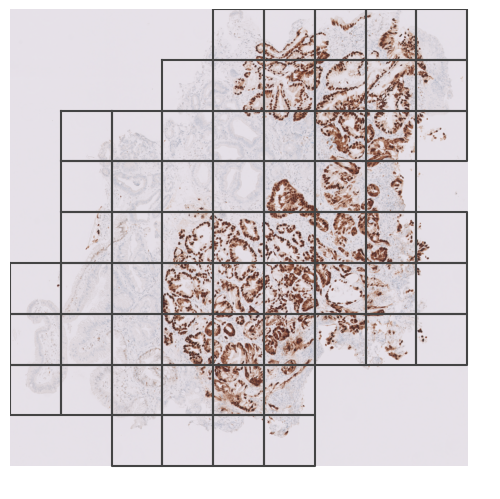

tensor([12, 49, 38, 26])


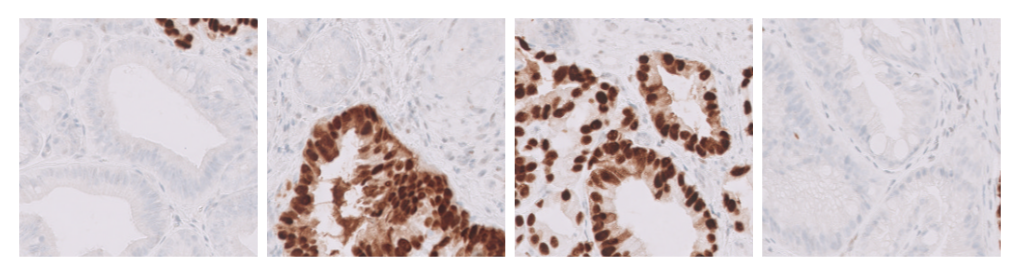

In [108]:
# Take biopsy 1361 from test and divide it into 256x256 patches
# img = plt.imread(os.path.join(BASE_DIR['test'], 'biopsies', '1361.png'))
img = plt.imread(os.path.join(BASE_DIR['test'], 'biopsies', '34.png'))

print(img.shape)

new_size = (2304, 2304)
# img = plt.imread(os.path.join(BASE_DIR['pathxl'], 'biopsies', '56_4.png'))
# new_size = (4096, 4096)
img = torch.tensor(img).permute(2, 0, 1).float() # (3, h, w)

img = torch.nn.functional.interpolate(img.unsqueeze(0), size=new_size, 
    mode='bilinear', align_corners=False)[0]

size = 256
quantile_range_threshold = 0.1

patches = torch.nn.functional.unfold(img.unsqueeze(0), 
    kernel_size=(size, size), 
    stride=(size, size)) # (1, 3*size*size, n_patches)
patches = patches.permute(0, 2, 1).reshape(-1, 3, size, size) # (n_patches, 3, size, size)

# Remove patches with low difference between the 75th and 1st percentile
qranges = torch.quantile(patches.view(patches.shape[0], -1), 0.75, dim=-1) - \
            torch.quantile(patches.view(patches.shape[0], -1), 0.01, dim=-1)
non_empty_idx = torch.where(qranges >= quantile_range_threshold)[0]

non_empty_patch_grid = torch.zeros((new_size[0]//size, new_size[1]//size))
non_empty_patch_grid[non_empty_idx // (new_size[1]//size), non_empty_idx % (new_size[1]//size)] = 1

plt.imshow(img.permute(1, 2, 0))
plt.axis('off')
# Draw square edges for every non-empty patch
for i in range(non_empty_patch_grid.shape[0]):
    for j in range(non_empty_patch_grid.shape[1]):
        if non_empty_patch_grid[i, j] == 1:
            plt.plot([j*size, j*size, (j+1)*size, (j+1)*size, j*size], 
                     [i*size, (i+1)*size, (i+1)*size, i*size, i*size], '#444444')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()

patches = patches[non_empty_idx]

# Plot 4 random patches
indices = torch.randperm(patches.shape[0])[:4]
print(indices) # 30, 36, 44, 16
# indices = [44, 36, 30, 16]
indices = [14, 23, 29, 36]
selected = torch.tensor(indices)
# Make grid of 4 patches with torchvision.utils.make_grid
grid = torchvision.utils.make_grid(patches[selected], nrow=4, padding=10, pad_value=1)
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
# Tight layout
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()